# Maximum amplitude angle for the fundamental QQNM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import CCE
from qnmfits.spatial_mapping_functions import *

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

plt.style.use("stylesheet.mplstyle")
fig_width = 246.0 * (1.0 / 72.27)
fig_height = fig_width / 1.618

In [2]:
l_max = 8
n_max = 7

mapping = [(2, 2, 0, 1, 2, 2, 0, 1)]
map = mapping[0]
lpp = 4
mpp = 4

start_times = [
    17.0,
    21.0,
    23.0,
    26.0,
    17.0,
    17.0,
    17.0,
    11.0,
    29.0,
    16.0,
    12.0,
    17.0,
    6.0,
]
simnums = [
    "0001",
    "0002",
    "0003",
    "0004",
    "0005",
    "0006",
    "0007",
    "0008",
    "0009",
    "0010",
    "0011",
    "0012",
    "0013",
]

In [3]:
def theta_max_finder(G, thetas):
    max_index = np.argmax(np.abs(G))
    return thetas[max_index] * (180 / np.pi)

In [4]:
phis = 0
thetas = np.linspace(-np.pi / 2, np.pi / 2, 10000)
Lon, Lat = np.meshgrid(phis, thetas)

In [5]:
theta_maxes = []
theta_maxes_error = []
sim_spins = []
sim_masses = []

QNMs = [
    (lam, mpp, n, p)
    for lam in np.arange(lpp, l_max + 1)
    for n in np.arange(0, n_max + 1)
    for p in (-1, +1)
]

for simnum, t0 in zip(simnums, start_times):

    sim = CCE.SXS_CCE(simnum, lev="Lev5", radius="R2")

    theta_max_options = []

    for t0_alt in np.arange(t0 - 5, t0 + 6, 1):

        best_fit = mapping_multimode_ringdown_fit(
            sim.times,
            sim.h,
            modes=QNMs.copy(),
            Mf=sim.Mf,
            chif=sim.chif_mag,
            t0=t0_alt,
            mapping_modes=mapping,
            spherical_modes=[(lam, mpp) for lam in np.arange(lpp, l_max + 1)],
        )

        F = spatial_reconstruction(np.pi / 2 - Lat, Lon, best_fit, map, l_max)
        theta_max = theta_max_finder(F, thetas)

        if t0_alt == t0:

            sim_spins.append(sim.chif_mag)
            sim_masses.append(sim.Mf)
            theta_maxes.append(theta_max)

        theta_max_options.append(theta_max)

    theta_error = max(theta_max_options) - min(theta_max_options)
    theta_maxes_error.append(theta_error)

In [6]:
spins = np.linspace(0, 0.99, 100)

theta_maxes_GA = []
theta_maxes_GB1 = []
theta_maxes_GB2 = []
theta_maxes_GC = []
theta_maxes_GD = []
theta_maxes_test = []

for spin in spins:

    G_Bi = spatial_prediction_quadratic(
        np.pi / 2 - Lat, Lon, map, l_max, spin, Qmu_B, s1=-2, s2=0
    )
    G_Bii = spatial_prediction_quadratic(
        np.pi / 2 - Lat, Lon, map, l_max, spin, Qmu_B, s1=-1, s2=-1
    )
    G_C = spatial_prediction_C(np.pi / 2 - Lat, Lon, map, spin)
    G_D = spatial_prediction_quadratic(np.pi / 2 - Lat, Lon, map, l_max, spin, Qmu_D)

    theta_maxes_GB1.append(theta_max_finder(G_Bi, thetas))
    theta_maxes_GB2.append(theta_max_finder(G_Bii, thetas))
    theta_maxes_GC.append(theta_max_finder(G_C, thetas))
    theta_maxes_GD.append(theta_max_finder(G_D, thetas))

/tmp/ipykernel_1944798/1804819811.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("viridis", 5)
/tmp/ipykernel_1944798/1804819811.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("figs/theta_max.pdf", bbox_inches="tight")
/tmp/ipykernel_1944798/1804819811.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig("figs/theta_max.pdf", bbox_inches="tight")
/data/vault/rvnd2/python_envs/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


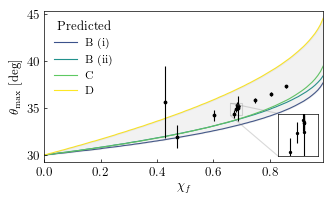

In [7]:
fig, ax = plt.subplots(figsize=(fig_width, fig_height))
colors = plt.cm.get_cmap("viridis", 5)
axins = zoomed_inset_axes(ax, 3.5, loc=4)

ax.plot(spins, theta_maxes_GB1, label=r"B (i)", color=colors(1), zorder=1)
ax.plot(spins, theta_maxes_GB2, label=r"B (ii)", color=colors(2), zorder=1)
ax.plot(spins, theta_maxes_GC, label="C", color=colors(3), zorder=1)
ax.plot(spins, theta_maxes_GD, label="D", color=colors(4), zorder=1)

axins.plot(spins, theta_maxes_GB1, label=r"B (i)", color="r", zorder=1)
axins.plot(spins, theta_maxes_GB2, label=r"B (ii)", color="b", zorder=1)
axins.plot(spins, theta_maxes_GC, label="C", color=colors(2), zorder=1)

ax.fill_between(spins, theta_maxes_GD, theta_maxes_GB1, color="gray", alpha=0.1)

for i, simnum in enumerate(simnums):
    
    ax.scatter(sim_spins[i], theta_maxes[i], s=3, color="k", zorder=2)
    ax.errorbar(
        sim_spins[i],
        theta_maxes[i],
        yerr=theta_maxes_error[i],
        markersize=3,
        color="k",
        zorder=2,
    )

    axins.scatter(sim_spins[i], theta_maxes[i], s=2, color="k", zorder=2)
    axins.errorbar(
        sim_spins[i],
        theta_maxes[i],
        yerr=theta_maxes_error[i],
        markersize=2,
        color="k",
        zorder=2,
        linestyle=":",
    )

x1, x2, y1, y2 = 0.66, 0.7, 34.2, 35.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xticks([])
axins.set_yticks([])
mark_inset(ax, axins, loc1=2, loc2=3, fc="none", ec="0.5", alpha=0.3, lw=0.8)

ax.legend(title="Predicted")
ax.set_xlim(0, 0.99)
ax.set_xlabel(r"$\chi_f$")
ax.set_ylabel(r"$\theta_{\rm max} \ \mathrm{[deg]}$")

plt.savefig("figs/theta_max.pdf", bbox_inches="tight")